In [362]:
import warnings
warnings.filterwarnings('ignore')
import cv2, traceback
import numpy as np
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import easyocr
import re


TypeError: Reader.__init__() got an unexpected keyword argument 'recognition'

In [3]:
data_dir = "../../data"

In [306]:

img = cv2.imread(os.path.join(data_dir,"test_aadhar","devraj_aadhar.jpg"))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = img.copy()
template = cv2.imread(os.path.join(data_dir,"template","Gujarati Front.png"),0)
# w, h = template.shape[::-1]



In [307]:
template.shape

(948, 1396)

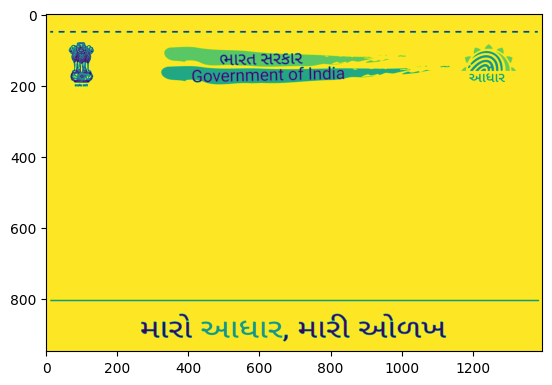

In [308]:
plt.imshow(template)

In [143]:
698/474

1.4725738396624473

In [27]:
#show image
def display_image(input_img, display_title=None, plt_width_height=None):
    if not plt_width_height is None:
      plt.rcParams['figure.figsize'] = plt_width_height
    im_shape = input_img.shape
    c = 3
    if len(im_shape) >= 3:
      c = im_shape[2]
    if len(im_shape) == 2:
      c = 1
    
    if c == 3:
      rgb_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_BGR2RGB)
      plt.imshow(rgb_img)
      
    if c == 1:
      plt.imshow(input_img,cmap='gray')
    
    plt.axis('off')
    plt.grid(False)
    if not display_title is None:
        plt.title(display_title)
    plt.show()

In [348]:
def clahe_enhance(img, is_debug=False):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(5,5))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    clahe_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    if is_debug:
        display_image(img,'input image',[8,10])
        display_image(clahe_img,'clahe enhanced',[8,10])
    return clahe_img


def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio = 0.65, reprojThresh = 1.5,thresh=20):
    # compute the raw matches and initialize the list of actual
    # matches
    matcher = cv2.DescriptorMatcher_create("BruteForce") 
   
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

  # loop over the raw matches
    for m in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    #print ('no. of matches:', len(matches)) 

  # computing a homography requires at least 4 matches
    if len(matches) > thresh:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i].pt for (_, i) in matches])
        ptsB = np.float32([kpsB[i].pt for (i, _) in matches])

        # print('ptsA shape:', ptsA.shape)
        # print('ptsB shape:', ptsB.shape)

        ptsA_ = ptsA.reshape(-1,1,2)
        ptsB_ = ptsB.reshape(-1,1,2)

        # print('ptsA_ shape:', ptsA_.shape)
        # print('ptsB_ shape:', ptsB_.shape)    

        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsB_, ptsA_, cv2.RANSAC, reprojThresh)

        _ptsB = cv2.perspectiveTransform(ptsB_,H)
        # print('_ptsA shape:', _ptsA.shape)

        _ptsB = _ptsB.reshape(ptsB.shape)
        # print('_ptsA shape:', _ptsA.shape)

        reprojection_error = 0.

        for i in range(len(ptsA)):
            reprojection_error += (ptsA[i][0] - _ptsB[i][0])**2 + (ptsA[i][1] - _ptsB[i][1])**2

        reprojection_error = np.sqrt(reprojection_error)/float(len(ptsA))
        # print("REPROJ ERROR", reprojection_error)
        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status, reprojection_error)

      # otherwise, no homograpy could be computed
    return None

def angle(pt1, pt2, pt0):
    dx1 = pt1[0] - pt0[0]
    dx2 = pt2[0] - pt0[0]
    dy1 = pt1[1] - pt0[1]
    dy2 = pt2[1] - pt0[1]

    return (dx1 * dx2 + dy1 * dy2) / np.sqrt((dx1 * dx1 + dy1 * dy1) * (dx2 * dx2 + dy2 * dy2) + 1e-10)

def distanceSq(p0, finalP):
    return np.sqrt((p0[0] - finalP[0]) * (p0[0] - finalP[0]) + (p0[1] - finalP[1]) * (p0[1] - finalP[1]))

def rectangleCheck_new(a, b):
    return ((a < 1.95 * b and a > 1.4 * b) or (a < 0.71 * b and a > b * 0.51))


def check_corner_validity_extended(corners, width, height):
    corners = np.array(corners).reshape(-1,2)
    for x, y in corners:
        if x < 5 or x >= (width-5) or y < 5 or y >=(height-5):
            return 0, "corners_outside_image"
        
        
    maxCosine = 0
    cornerPts = [ [p[0],p[1]] for p in corners]
    for j in range(2,5):
        # find the maximum cosine of the angle between joint edges
        # print('finding angles for corners:', j % 4, j-2, j-1)
        cosine = abs(angle(cornerPts[j % 4], cornerPts[j - 2], cornerPts[j - 1]));
        maxCosine = max(maxCosine, cosine);
    
    
    if maxCosine >= 1.5:
        print(maxCosine)
        return 0, "maxCosine fail"
    
    dis = []
    for i in range(4):  
        i2 = i + 1  
        if i2 == 4:
            i2 = 0
        dis.append(distanceSq(cornerPts[i], cornerPts[i2]))

    rectangleCh = True
    for i in range(3):
        if not rectangleCheck_new(dis[i], dis[i+1]):
            return 0, "rect_sides_ratioCheck failed"
        
    
    
    return 1, "valid_corners"

def corner_detection_and_cropping(img_name,debug = False,visualise=False):
    '''
    parameters: 
        img_name: path of any image


    returns:
        return cropped region of tag or None value
    '''
    
    
    app_img = cv2.imread(img_name)
    
    
    template_img  = cv2.imread(os.path.join(data_dir,"template","Gujarati Front.png"))

    #sift feature extraction
    sift  = cv2.xfeatures2d.SIFT_create()
    kps_template, feat_template = sift.detectAndCompute(template_img, None)

    template_corners_outer = np.array([[0, 40],
                             [698, 40],
                             [698, 474],
                             [0, 474]], dtype=np.float32).reshape(-1,1,2)


    clahe_img = clahe_enhance(deepcopy(app_img))
    app_kps, app_feat = sift.detectAndCompute(deepcopy(clahe_img), None)

    if visualise:
        display_image(clahe_img)

    out = matchKeypoints(app_kps,kps_template, app_feat,feat_template)
    if out is None:
        if debug:
             print("template_homography_not_found")
       
        return None


    matches, H, status, reprojection_error = out
    app_corners_outer = cv2.perspectiveTransform(template_corners_outer, H)
    app_corners_outer = app_corners_outer.reshape(4,2)
    app_corners_outer = app_corners_outer.astype(int).tolist()
    corner_validity = check_corner_validity_extended(app_corners_outer, app_img.shape[1], app_img.shape[0])

    if False:
    # if corner_validity[0]==0:
    #     if debug:
    #         print(corner_validity[1])
    #         print(app_corners_outer)
    #     return None
        print()
    
    else:
        
        if debug:
            print(app_corners_outer)


        Top_left, Top_right, Bottom_right, Bottom_left = app_corners_outer

        # print(np.array(app_corners_outer))
        dst_corner =  np.array([[0, 0],
                             [720, 0],
                             [720, 480],
                             [0, 480]], dtype=np.float32).reshape(-1,1,2)
        M = cv2.getPerspectiveTransform(np.array(app_corners_outer,np.float32),dst_corner)
        dst = cv2.warpPerspective(app_img,M,(720,480))
    
        if visualise:
            display_image(dst)
           

        return dst
    

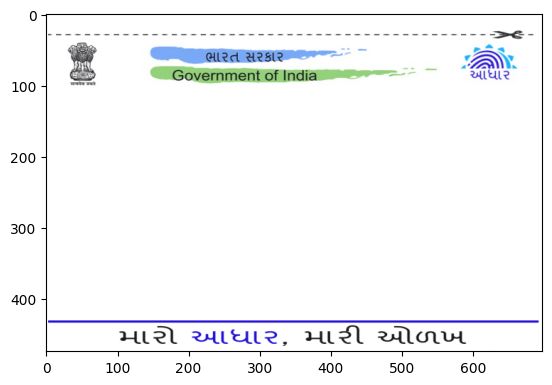

In [349]:
# query_img = cv2.imread(os.path.join(data_dir,"test_aadhar","kashi_aadhar.jpg"))
# train_img = cv2.imread(os.path.join(data_dir,"template","aadhar template front.jpg"))
# train_img = cv2.resize(train_img, (800,600))


template_img = cv2.imread(os.path.join(data_dir,"template","Gujarati Front.png"))
plt.imshow(template_img)

In [350]:
template_img.shape

(474, 698, 3)

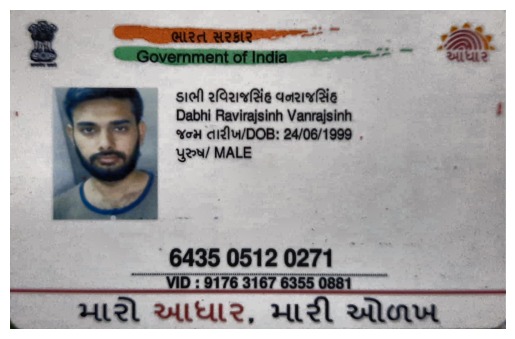

[[-17, 41], [1658, 38], [1595, 1018], [86, 1014]]


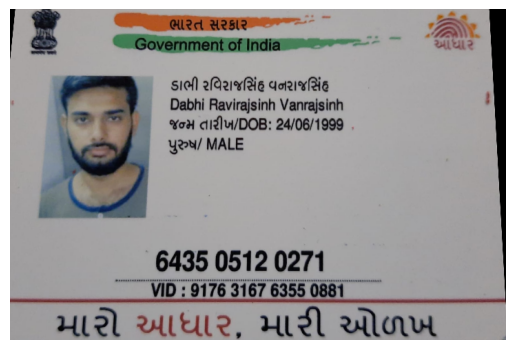

In [359]:
corners = corner_detection_and_cropping(os.path.join(data_dir,"test_aadhar","ravirajsinh_aadhar.jpg"),debug=True,visualise=True)

In [360]:
res = reader.readtext(corners,detail=0)

In [361]:
res

['cu?d ?251?',
 'Government of India',
 'ee?',
 '2fzixfie Yolzirfie',
 'Dabhi Ravirajsinh Vanrajsinh',
 'Yoh dizlu/DOB: 24/06/1999',
 'Y?tl MALE',
 '6435 0512 0271',
 'VID',
 '9176 3167 6355 0881',
 '421 ?uul? _',
 'H? &au',
 'sicl']

In [374]:
for x in res:
    print(re.findall("\d{2}/\d{2}/\d{4}$",x))

[]
[]
[]
[]
[]
['24/06/1999']
[]
[]
[]
[]
[]
[]
[]
